# Анализ продаж игр

### Описание:

В интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры, нужно выявить определяющие успешность игры закономерности по данным продаж до 2016 года. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


### Данные:
- **Name** — название игры
- **Platform** — платформа
- **Year_of_Release** — год выпуска
- **Genre** — жанр игры
- **NA_sales** — продажи в Северной Америке (миллионы проданных копий)
- **EU_sales** — продажи в Европе (миллионы проданных копий)
- **JP_sales** — продажи в Японии (миллионы проданных копий)
- **Other_sales** — продажи в других странах (миллионы проданных копий)
- **Critic_Score** — оценка критиков (максимум 100)
- **User_Score** — оценка пользователей (максимум 10)
- **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### План проекта:

1. [**Распаковка данных**](#id1)
2. [**Предобработка данных**](#id2)
    - [Приведение типов данных](#id3)
    - [Обработка пропусков](#id4)
    - [Обработка выбивающихся значений и дубликатов](#id5)
    - [Подсчет суммарных продаж](#id6)
3. [**Исследовательский анализ**](#id7)
    - [Анализ игр по годам выпуска](#id8)
    - [Анализ количества и продаж игр по платформам](#id9)
    - [Анализ продаж игр за актуальный период](#id10)
    - [Анализ зависимости отзывов зрителей на продажи](#id11)
    - [Анализ игр по жанрам](#id12)
4. [**Портреты пользователей по регионам**](#id13)
    - [ Самые популярные платформы (ТОП-5)](#id14)
    - [Самые популярные жанры (ТОП-5)](#id15)
    - [Влияние рейтинга ESRB](#id16)
5. [**Проверка гипотез**](#id17)
    - [Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#id18)
    - [Средние пользовательские рейтинги жанров Action и Sports разные](#id19)
6. [**Общий вывод**](#id20)

## Распаковка данных <a id='id1'></a>

In [2]:
import pandas as pd
import numpy as np
import os
if os.path.exists('games.csv'):
    games = pd.read_csv('games.csv')
elif os.path.exists('/datasets/games.csv'):
    games = pd.read_csv('/datasets/games.csv')
else:
    print("Проверьте правильность пути к датасету")

Посмотрим общую информацию о датасете функцией `info()`:

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Оценим общий вид данных:

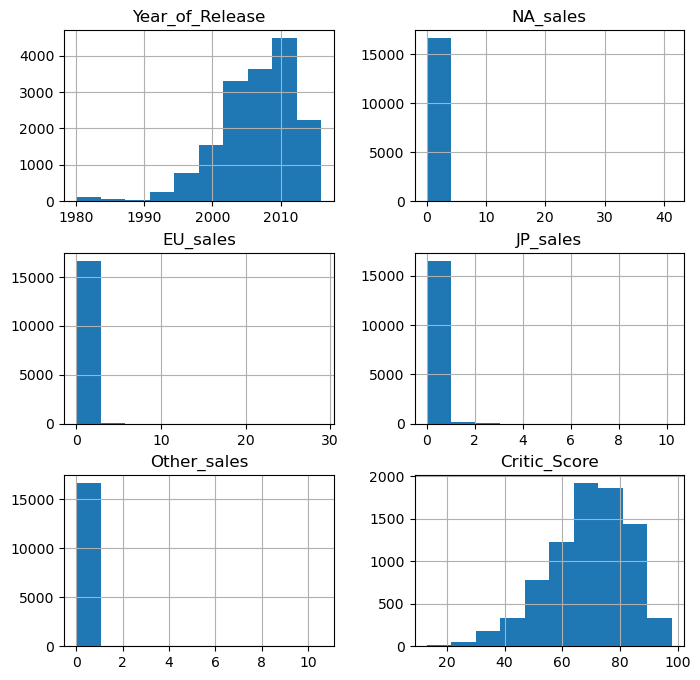

In [4]:
games.hist(figsize=(8,8));

По гистораммам сразу видно, что продажи каждого эксзмпляра (игры) во всех регионах в основном не превышают более 5 млн. копий, соответственно, есть выбивающиеся данные. Скорее всего это очень популярные игры. Нужно будет обратить на них внимание, возможно, исключив из датасета в зависимости от их влияния на общие продажи.

Средняя оценка вполне ожидаемо находится между 6-8. С каждам годом количество выпущенных игр растет (в общем), но наблюдается спад после 2010 года.

## Предобработка данных <a id='id2'></a>

### Приведение типов данных<a id='id3'></a>

Приведем названия столбцов к стандартному виду: к нижнему регистру функцией `map()` применим строковую функцию `lower` к столбцам датафрейма:

In [5]:
games.columns = map(str.lower, games.columns)
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Большинство численных данных уже имеют тип `float`, столбец **name** имеет тип `object`, что логично. Рассмотрим столбцы  **platform**, **genre**, **user_score** и **rating**:

In [6]:
games.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Это категориальные данные, поэтому меняем тип, аналогично с **platform** и **genre**:

In [7]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Для начала обработаем пропуски ранее, для корректного переврда в категориальные данные. Обозначим пропущенные значения в рейтинге как не определенные, т.к. это не просто пропуски, а просто выпущенным играм рейтинг не присваивался, т.к. рейтинг ESRB присваивается лишь играм, выпущенным в США и Канаде. Обозначим ND - "Not Determined".

In [8]:
games['rating'] = games['rating'].fillna('ND')
games['rating'] = games['rating'].astype('category')

In [9]:
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [10]:
games['genre'] = games['genre'].astype('category')

In [11]:
games.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Здесь мы видим как численные данные, как и значение "tbd", которое означает, что рейтинг еще не был определен. Значения "tbd" в столбце **user_score** изменим на NaN. 

In [12]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = games['user_score'].astype('float')

Стобец **year_of_releae** переведем в тип `int` после обработки пропусков.

### Обработка пропусков <a id='id4'></a>

Пропуски имеются в столбцах: **name**, **year_of_release**, **genre**, **critic_score**, **user_score**, **rating**

In [13]:
print('Размер таблицы до обработки: ', games.shape[0])

Размер таблицы до обработки:  16715


1. Год выпуска игры (**year_of_release**)

Удалим пропуска в этом столбце, т.к. данные года выпуска игр нам важны для анализа, проверим количество пропусков.

In [14]:
games.query('year_of_release.isna()').shape[0]

269

Число невелико, поэтому удаляем. Пропуски в этом столбце могут быть связаны с отсутствием данных об играх: либо игры не популярны и оних в целом мало информации, либо очень старые, поэтому информации также нет.

In [15]:
games = games.dropna(subset=['year_of_release'])
games = games.reset_index(drop=True)

И переведем в тип `int`:

In [16]:
games['year_of_release'] = games['year_of_release'].astype('int')

2. Название игры (**name**)

In [17]:
games.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
652,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,ND
14022,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,ND


Результатом является 2 игры "ноу нейма", о них практически нет данных, к тому же продаж не очень много, поэтому просто удалим их, таким образом избавимся от пропусков в **genre**.

In [18]:
games = games.dropna(subset=['name'])
games = games.reset_index(drop=True);

Пропуски связаны просто с отстутствием инофрмации об играх. То есть скорее всего датасет составлялся из других таблиц, поэтому могла произойти ошибка.

3. Оценка критиков (**critic_score**) и оценка пользователей (**user_score**)

In [19]:
games.query('critic_score.isna() & user_score.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,ND
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,ND
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,ND
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,ND
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,ND
...,...,...,...,...,...,...,...,...,...,...,...
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,ND
16440,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,ND
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,ND
16442,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,ND


Довольно много игр, у которых никаких оценок нет, удалять их точно не вариант, это могло быть вызвано отсутствием данных, или же если данные об оценках импортировались из некоторого источника, то произошел сбой и данные не считались.

Аналогичная ситуация, скорее всего, с пропусками только в оценке критиков или зрителей. У нас нет оснований полагать, что какие-то данные из датасета точно коррелируют с оценками зрителей и критиков, поэтому оставим пропуски в данных. 

5. Рейтинг (**rating**)

In [20]:
games.query('rating.isna()').shape[0]

0

Рейтинг мы заполнили при приведении типов данных.

In [21]:
print('Размер таблицы после обработки: ', games.shape[0])

Размер таблицы после обработки:  16444


In [22]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  int32   
 3   genre            16444 non-null  category
 4   na_sales         16444 non-null  float64 
 5   eu_sales         16444 non-null  float64 
 6   jp_sales         16444 non-null  float64 
 7   other_sales      16444 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       7463 non-null   float64 
 10  rating           16444 non-null  category
dtypes: category(2), float64(6), int32(1), object(2)
memory usage: 1.1+ MB


В целом, заполнение оценок было необязательным, т.к. получилось заполнить совсем мало строк.

### Анализ дубликатов <a id='i5'></a>

Проверим количество дубликатов.

In [23]:
games.duplicated().sum()

0

Дубликатов нет, поэтому мы можем идти дальше. Могут быть дубликаты в именах игр, т.к. мы рассматриваем продажи на разных платформах.

In [24]:
print('Размер таблицы после обработки: ', games.shape[0])

Размер таблицы после обработки:  16444


### Подсчет суммарных продаж <a id='id6'></a>

In [25]:
games['sum_sales'] = games['jp_sales'] + games['eu_sales'] + games['na_sales'] + games['other_sales']

Посмотрим что осталось после предобработки данных:

In [26]:
temp = games.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
    print('-'* 25)
    print(col_l, temp[col_l].unique())
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16444 non-null  object  
 2   year_of_release  16444 non-null  int32   
 3   genre            16444 non-null  category
 4   na_sales         16444 non-null  float64 
 5   eu_sales         16444 non-null  float64 
 6   jp_sales         16444 non-null  float64 
 7   other_sales      16444 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       7463 non-null   float64 
 10  rating           16444 non-null  category
 11  sum_sales        16444 non-null  float64 
dtypes: category(2), float64(7), int32(1), object(2)
memory usage: 1.2+ MB
None
-------------------------
name ['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka 

## Исследовательский анализ данных <a id='id7'></a>

### Анализ игр по годам выпуска <a id='id8'></a>

Рассмотрим распределние количества выпущенных игр по годам. Сразу импортируем нужные библиотеки для визуализации и расчетов.

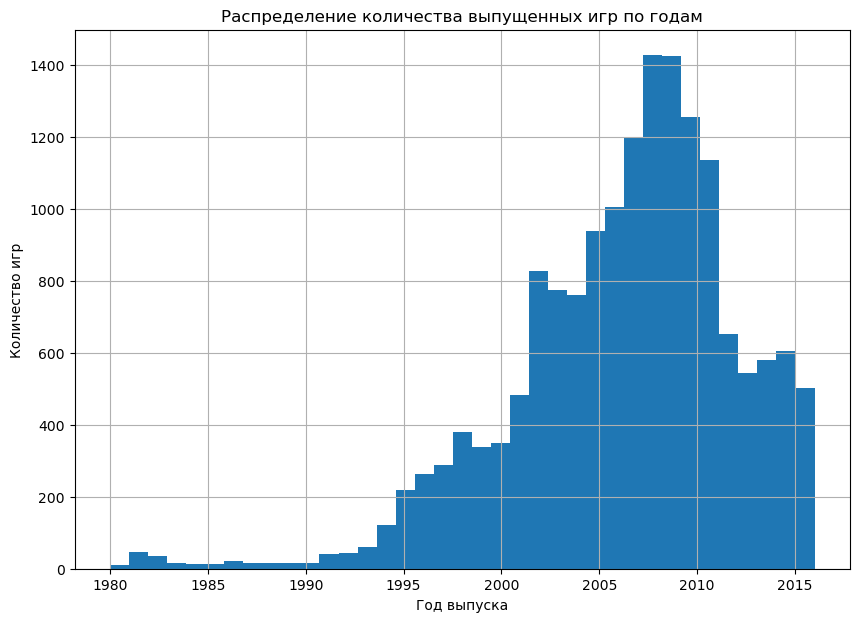

In [27]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns 
import numpy as np

cmap = ListedColormap(sns.color_palette())

games.hist(column='year_of_release',figsize=(10,7), grid=True, bins=37);
plt.xlabel('Год выпуска');
plt.ylabel('Количество игр');
plt.title('Распределение количества выпущенных игр по годам');

Из полученной гистограммы видно, что до 2010 года количество выпускаемых игр растет. Ориентировочно после 2008 года количество выпускаемых игр начинает убывать. 

### Анализ количества и продаж игр по платформам <a id='id9'></a>

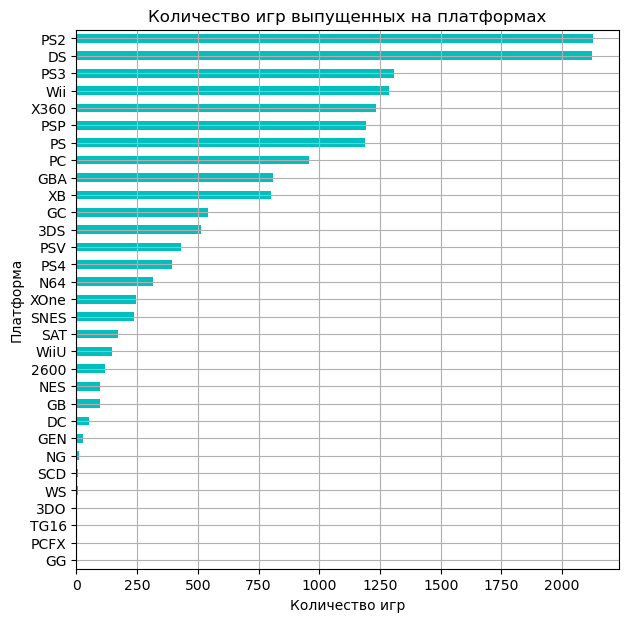

In [28]:
games.groupby(by='platform').count().sort_values(by='name').plot.barh(y='name', legend=False, figsize=(7,7), color='c', grid=True)
plt.xlabel('Количество игр');
plt.ylabel('Платформа');
plt.title('Количество игр выпущенных на платформах');

Больше всего игр выпускалось на платформе DS, PS2, PS3, но можно ли уствержать, что это самые популярные платформы сейчас? Возможно к настоящему времени эти платформы устарели, а так много игр выпускалось на них за счет долгой популярности на рынке в прошлом. 

Рассмотрим также продажи игр на платформах:

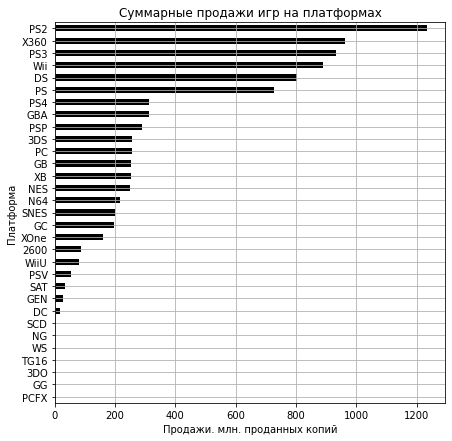

In [30]:
games.groupby(by='platform').sum().sort_values(by='sum_sales').plot.barh(y='sum_sales', legend=False, figsize=(7,7), color='k', grid=True)
plt.xlabel('Продажи. млн. проданных копий');
plt.ylabel('Платформа');
plt.title('Суммарные продажи игр на платформах');

Здесь также лидируют PS2 и PS3, но еще появляется XOne. Игр там выходит не так много, как количество продаж, что означает, что платформа довольно популярна. Опять же, мы оцениваем данные с 1985 года, поэтому рассмотрим актуальность платформ, построив `heatmap()`:

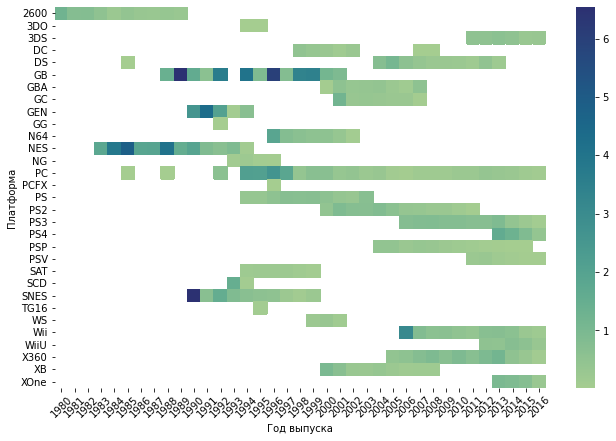

In [31]:
fig, heat = plt.subplots(figsize = (11,7))
heat = sns.heatmap(games.pivot_table(index='platform',columns='year_of_release',values='sum_sales'),cmap='crest')
plt.xlabel('Год выпуска');
plt.ylabel('Платформа');
plt.xticks(rotation=45)
plt.show()

На графике виден выброс в платформе DS, платформы не существовало в 1985 году.

In [32]:
games = games.query('~(platform == "DS" & year_of_release < 2000)')
games = games.reset_index(drop=True)

Грубо говоря, "продолжительность жизни" платформы составляет 10 лет, но есть исключения, например, платформа PC (то есть компьютер), логично, что он как был популярен 20 лет назад, так и сейчас, потому что далеко не все геймеры покупают приставки.

Из графика видно, что
- платформа PSP устратила популярность за последние годы, в 2016 году продаж совсем нет
- платформа PS2, которая в топе рейтинка по продажам и выпуску игр в последнее время не актуальна
- судя по интенсиваности цвета, платформа из топа рейтинга утрачивает популярность
- довольно много платформ в датасете уже неактуальны, поэтому статистику они могут портить
- популярными платформами на данный момент являются: XOne, X360, WiiU, Wii, PSV, PS4, PS3, PC, 3DS

Можно сделать вывод, что **актуальным периодом** является промежуток времени с 2014 по 2016 годы, т.к. по первой гистограмме видно, что после 2013 года произошел спад, поэтому для анализа высокие показатели 2013 года не подходят. Также на тепловой карте видно, что давольно много платформ до 2014 года могут портить статистику.

Таблица по актуальным годам:

In [33]:
actual_games = games.query('year_of_release >= 2014')

### Анализ продаж игр за актуальный период <a id='id10'></a>

Составим таблицу по продажам в актуальные годы:

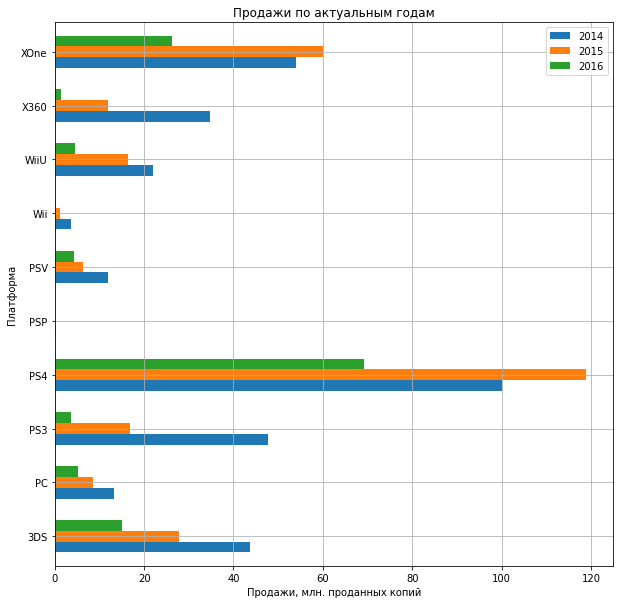

In [34]:
actual_games_2014 = actual_games.query('year_of_release == 2014').pivot_table(index='platform', values='sum_sales',aggfunc='sum')
actual_games_2014.columns = ['2014']
actual_games_2015 = actual_games.query('year_of_release == 2015').pivot_table(index='platform', values='sum_sales',aggfunc='sum')
actual_games_2015.columns = ['2015']
actual_games_2016 = actual_games.query('year_of_release == 2016').pivot_table(index='platform', values='sum_sales',aggfunc='sum')
actual_games_2016.columns = ['2016']
actual_games_sales = actual_games_2014.join(actual_games_2015).join(actual_games_2016)

actual_games_sales.plot.barh(grid=True, figsize=(10,10),width=0.6);
plt.xlabel('Продажи, млн. проданных копий');
plt.ylabel('Платформа');
plt.title('Продажи по актуальным годам');

Не смотря на рост выпуска игр с 2014 года продажи игр, падают пратктически по всем платформам, но также нужно учесть, что данные за 2016 год могут быть не точными и не полными. 

В целом, самыми популярными платформами являются XOne и PS4.

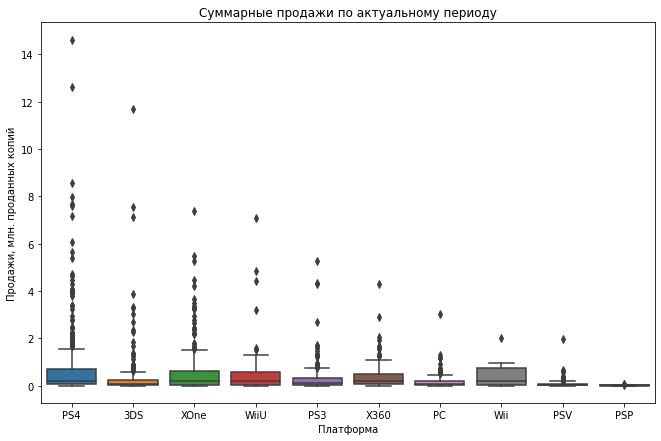

In [35]:
fig, box = plt.subplots(figsize = (11,7))
box = sns.boxplot(x=actual_games['platform'],y=actual_games['sum_sales'])
plt.title('Суммарные продажи по актуальному периоду');
plt.xlabel('Платформа');
plt.ylabel('Продажи, млн. проданных копий');

Рассмотрим диаграмму размаха продаж по максимумам (то есть продажи, которые больше третьего квартиля данных по продажам):

In [36]:
actual_games.quantile([.75])

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,sum_sales
0.75,2016.0,0.12,0.12,0.04,0.04,81.0,7.8,0.35


75% игр имеют продажи менее 0.35 млн. копий, тогда:

In [37]:
actual_games_max = actual_games.query('sum_sales > 0.35')

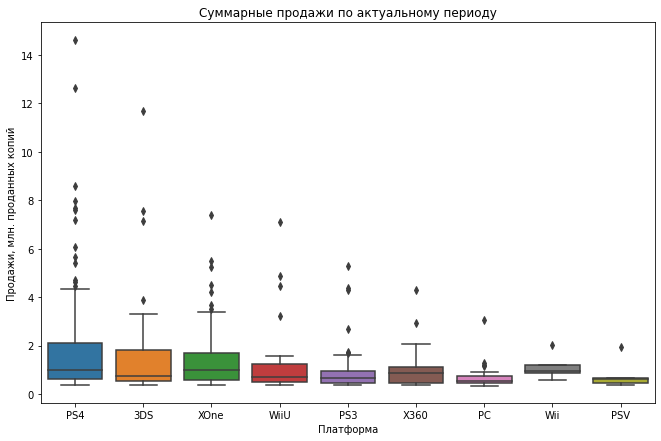

In [38]:
fig, box = plt.subplots(figsize = (11,7))
box = sns.boxplot(x=actual_games_max['platform'] ,y=actual_games_max['sum_sales'])
plt.title('Суммарные продажи по актуальному периоду');
plt.xlabel('Платформа');
plt.ylabel('Продажи, млн. проданных копий');

Сравним трех претендентов: платформы **XOne**, **PS4** всё еще оставются, появляется платформа **WiiU**. Её можно равнить с X360, но если посмотреть на горизонтальную гистограмму по продажам, то можно сказать, что X360 была популярнее в 2014, а вот популярность WiiU в 1016 выше. 

Основные продажи у этих платформ сосредоточены до 0.5 млн. проданных копий, но присутствует очень много выбивающихся значений, то есть на этих платформах выпускаются очень популярные игры, продажи которых очень вкелики.

P.S. не смотря на "широкий ящик" алатформы Wii как претендента мы ее рассматривать не будем, т.к. основные продажи сосредоточены до 1 млн. проданных копий, а выбивающихся значений почти нет.

### Анализ зависимости отзывов зрителей на продажи <a id='id11'></a>

Рассмотрим платформу **XOne**, берем среднее по продажам между PS4 и WiiU.

Для начала рассмотрим распределение оценок игр на платформе:

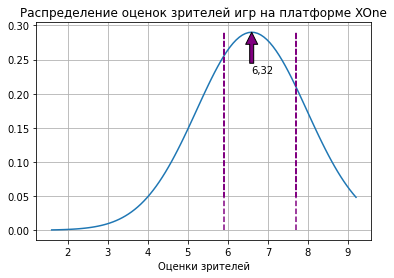

In [39]:
from scipy.stats import norm

actual_games_xone = actual_games.query('platform == "XOne"')
xone_user_score = actual_games_xone['user_score']

x = np.linspace(xone_user_score.min(), xone_user_score.max(), 100)
y = norm.pdf(x, xone_user_score.mean(), xone_user_score.std())
plt.annotate('6,32', xy=(xone_user_score.mean(), 0.29),  xycoords='data',
            xytext=(xone_user_score.mean(), 0.23), textcoords='data',
            arrowprops=dict(facecolor='purple'))
x1 = np.full(shape=len(y),fill_value=5.9) # 25%
x2 = np.full(shape=len(y),fill_value=7.7) # 75%
plt.plot(x, y)
plt.plot(x1, y, linestyle='dashed', color='purple')
plt.plot(x2, y, linestyle='dashed', color='purple')
plt.grid()
plt.xlabel('Оценки зрителей');
plt.title('Распределение оценок зрителей игр на платформе XOne');
plt.show()

Средняя оценка зрителей на платформе XOne около 6, основная часть оценок находится ориентировочно от 6 до 8.

**Рассмотрим зависимость продаж игр от оценок зрителей:**

In [40]:
print('Коэффициент корреляции оценок зрителей и продаж: {0:.4f}'.format(actual_games.corr()['user_score']['sum_sales']))

Коэффициент корреляции оценок зрителей и продаж: -0.0131


In [41]:
print('Коэффициент корреляции оценок критиков и продаж: {0:.4f}'.format(actual_games.corr()['critic_score']['sum_sales']))

Коэффициент корреляции оценок критиков и продаж: 0.3281


По коэффициенту корреляции можно сказать, что зависимость продаж от отзывов критиков более выражена, чем от отзывов зрителей. Тем не менее, корреляция недостаточно велика, чтобы утверждать о какой-либо зависимости.

Построим диаграмму рассеяния зависимости продаж от **оценок зрителей** и **оценок критиков** на платформе XOne и др. за актуальный период:

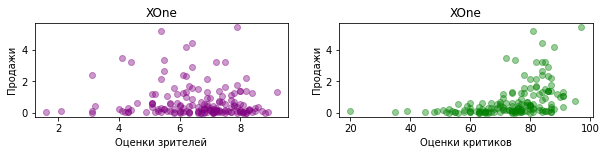

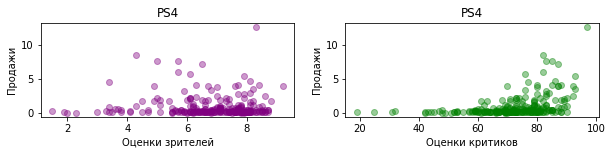

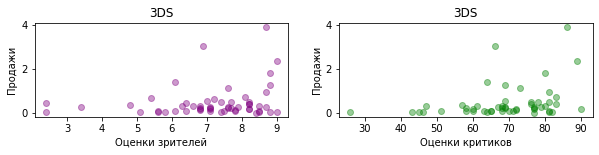

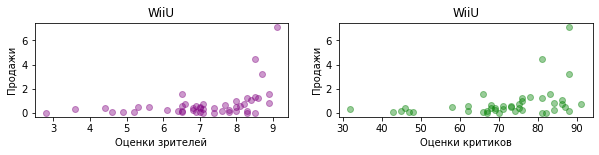

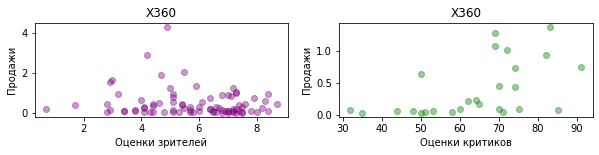

In [42]:
platforms = ["XOne", "PS4","3DS","WiiU","X360"]
counter = 0
for p in platforms:
    counter += 1
    data = actual_games.query('platform == @p')
    plt.figure(figsize=(10,10))
    plt.subplot(5,2,counter)
    plt.scatter(data['user_score'], data['sum_sales'], color='purple', alpha=0.4)
    plt.xlabel('Оценки зрителей')
    plt.ylabel('Продажи')
    plt.title('{0}'.format(p))
    counter += 1
    plt.subplot(5,2,counter)
    plt.scatter(data['critic_score'], data['sum_sales'], color='green', alpha=0.4)
    plt.xlabel('Оценки критиков')
    plt.ylabel('Продажи')
    plt.title('{0}'.format(p))
plt.show();

В целом, по корреляции видно, что зависимости нет. Также по диаграммам рассеяния также не наблюдается явной зависимости. При этом видно, что игры, имеющие высокие оценки как критиков, так и зрителей иногда имеют высокие продажи.

Можно сделать вывод, что продажи не зависят от оценок зрителей и критиков, как на платформе XOne, так и на всех платформах за актуальный период. В основном, игры, у которых большие продажи имеют оценки более 5, а так оценки сосредоточены между первым и третим картилями, что подтверждает построенное распределение.

### Анализ игр по жанрам <a id='id12'></a>

Построем гистограмму продаж и количества проданных копий по жанрам:

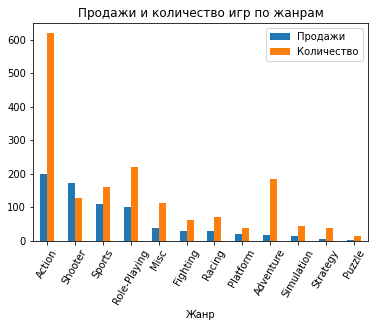

In [43]:
actual_genre = actual_games.pivot_table(index='genre', values='sum_sales',aggfunc=['sum','count'])
actual_genre.columns = ['sales','count']
genres = actual_genre.sort_values(by='sales',ascending=False).plot.bar()
plt.legend(['Продажи', 'Количество']);
plt.xticks(rotation=60);
plt.title('Продажи и количество игр по жанрам');
plt.xlabel('Жанр');

По получившейся гистограмме по продажам лидируют жанры **Action**, **Shooter** и **Sports** - это самые популярные жанры среди пользователей.

А **Puzzle**, **Strategy** и **Simulation** самые не популярные игры. 

Но для анализа прибыльности нам необходимо также учитывать количество проданных игр, поэтому построем гистограмму со следующим отношением:

$$Прибыль = \frac{Продажи}{Количество}$$

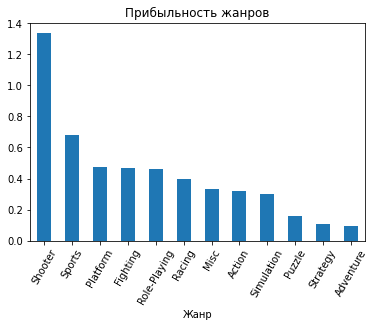

In [44]:
actual_genre['ratio'] = actual_genre['sales']/actual_genre['count']
actual_genre.sort_values(by='ratio',ascending=False).plot.bar(y='ratio', legend=False)
plt.xticks(rotation=60);
plt.title('Прибыльность жанров');
plt.xlabel('Жанр');

Получаем следующее:
- игры жанра Action далеко не самые прибыльные, хоть и самые популярные, скорее всего стоимость таких игр очень невелика, от этого отчасти и большой спрос
- **Shooter** - жанр, который является и одним из самых популярных, и самым прибыльным 
- **Platform** и **Sports** также являютя одними из самых прибыльных жанров
- Puzzle самый непопулярный жанр, но по прибыльности он 3-ий с конца
- **Strategy** и **Adventure** - самые неприбыльные жанры

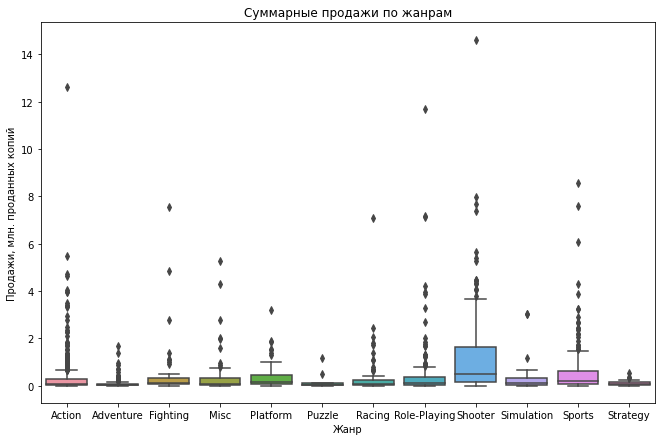

In [45]:
fig, box = plt.subplots(figsize = (11,7))
box = sns.boxplot(x=actual_games['genre'] ,y=actual_games['sum_sales'])
plt.title('Суммарные продажи по жанрам');
plt.xlabel('Жанр');
plt.ylabel('Продажи, млн. проданных копий');

## Портреты пользователей по регионам  <a id='id13'></a>

### Самые популярные платформы (ТОП-5) <a id='id14'></a>

Рассматриваем только актуальный период. Нет такого, что люди покупают игры заранее, поэтому учитывать в портрете предыдущие года не стоит, к тому же наблюдается большой спад по выпуску игр, что может дать искажение в предсказании.

**1. Северная Америка (NA)**

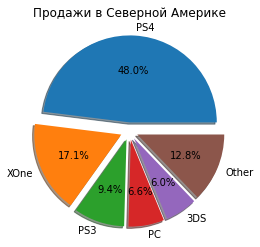

In [46]:
platf = actual_games.pivot_table(index='platform', values=['na_sales','eu_sales','jp_sales'], aggfunc=['sum'])
platf.columns = ['na','eu','jp']

platf_sorted = platf.sort_values(by='na',ascending=False)
platf_sorted.iloc[5] = platf_sorted.iloc[5:].sum()
platf_sorted = platf_sorted.rename(index={platf_sorted.iloc[5].name: 'Other'}).head(6)

plt.pie(platf_sorted['na'], labels=platf_sorted.index, explode=(0.1,0.1,0.1,0.1,0.1,0.1),autopct='%1.1f%%',shadow=True)
plt.title('Продажи в Северной Америке')
plt.show()

#### ТОП-5:
1. **PS4** - практически половина игр преобретается на платформе, одна из самых популярных платформ по суммарным продажам в мире, возможно пользователи Северной Америки вносят наибольший вклад в статистику по продажам этой платформы.
2. **XOne** - практически четверть пользователей приобретают игры на данной платформе.
3. **PS3** - платформой пользуется почти такой же процент игроков, как и платформами на 4-ом и 5-ом местах. Это может быть связано с тем, что платформа уже теряет свою актуальность, пользователи переходят на PS4.
4. **PC** - в данном случае платформа не теряет актуальность, а скорее пользователи стали предпочитать приставки, вместо компьютеров
5. **X360** - доля невелика, видимо, платформа теряет актуальность

**2. Европа (EU)**

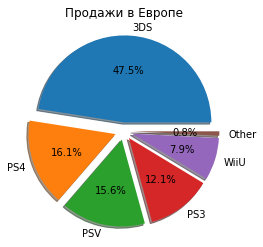

In [47]:
platf_sorted = platf.sort_values(by='eu',ascending=False)
platf_sorted.iloc[5] = platf_sorted.iloc[5:].sum()
platf_sorted = platf_sorted.rename(index={platf_sorted.iloc[5].name: 'Other'}).head(6)

plt.pie(platf_sorted['eu'], labels=platf_sorted.index,explode=(0.1,0.1,0.1,0.1,0.1,0.1),autopct='%1.1f%%',shadow=True)
plt.title('Продажи в Европе')
plt.show()

#### ТОП-5:
1. **3DS** - треть пользователей преобретает игры на данной платформе.
2. **PSV** - четверть пользователей, не критически больше, чем на 3DS.
3. **PS4** - пятая часть пользователей, возможно в Европе платформа еще не обрела популярность.
4. **PS3** - более старая версия третьего места, практически пятая часть пользователей.
5. **WiiU** - платформа еще набирает популярность, поэтому доля пользователей невелика.

**3. Япония (JP)**

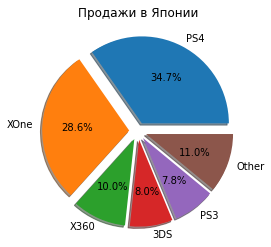

In [48]:
platf_sorted = platf.sort_values(by='jp',ascending=False)
platf_sorted.iloc[5] = platf_sorted.iloc[5:].sum()
platf_sorted = platf_sorted.rename(index={platf_sorted.iloc[5].name: 'Other'}).head(6)

plt.pie(platf_sorted['jp'], labels=platf_sorted.index,explode=(0.1,0.1,0.1,0.1,0.1,0.1),autopct='%1.1f%%',shadow=True)
plt.title('Продажи в Японии')
plt.show()

#### ТОП-5:
1. **PS4** - треть пользователей приобретает игры на платформе.
2. **XOne** - также треть пользователей, совсем небольшой процент отставания от первого места.
3. **X360** - популярность платформы в 2 раза меньше, чем у лидеров топа.
4. **PS3** - процент пользователей невелик, вероятно из-за перехода на PS4.
5. **WiiU** - менее 10% пользователей, предполагаем, что платформа набирает популярность

**Вывод:**

- Примечательно то, что PC входит в ТОП-5 только в Северной Америке, что означает, что люди в общем стали чаще играть в игры на приставках, нежели на персональных компьютерах.

- В Северной Америке есть явный лидер по продажам - PS4, большинство пользователей предпочитают эту платформу.

- В Европе также лидер есть, но не такой значительный - 3DS. Платформа PS в целом в Европе не так популярна как в других регионах.

- В Японии популярных платформы по сути две - PS4 и XOne. Платформы конкурируют практически на равных.

### Самые популярные жанры (ТОП-5) <a id='id15'></a>

**1. Северная Америка (NA)**

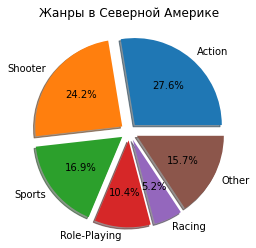

In [49]:
genres = actual_games.pivot_table(index='genre', values=['na_sales','eu_sales','jp_sales'], aggfunc=['sum'])
genres.columns = ['na','eu','jp']

genres_sorted = genres.sort_values(by='na',ascending=False)
genres_sorted.iloc[5] = genres_sorted.iloc[5:].sum()
genres_sorted = genres_sorted.rename(index={genres_sorted.iloc[5].name: 'Other'}).head(6)

plt.pie(genres_sorted['na'], labels=genres_sorted.index,explode=(0.1,0.1,0.1,0.1,0.1,0.1),autopct='%1.1f%%',shadow=True)
plt.title('Жанры в Северной Америке')
plt.show()

#### ТОП-5:
1. **Action** - почти треть пользователей предпочитает этот жанр игр.
2. **Shooter** - пятая часть пользователей предпочитает этот жанр игр.
3. **Sports** 
4. **Role-playing** 
5. **Racing** 

3 первых позиции являются одними из самых популярных жанров по миру.

**2. Европа (EU)**

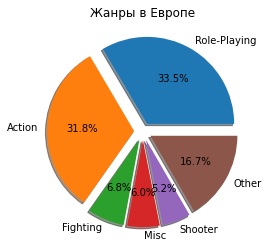

In [50]:
genres_sorted = genres.sort_values(by='eu',ascending=False)
genres_sorted.iloc[5] = genres_sorted.iloc[5:].sum()
genres_sorted = genres_sorted.rename(index={genres_sorted.iloc[5].name: 'Other'}).head(6)

plt.pie(genres_sorted['eu'], labels=genres_sorted.index,explode=(0.1,0.1,0.1,0.1,0.1,0.1),autopct='%1.1f%%',shadow=True)
plt.title('Жанры в Европе')
plt.show()

#### ТОП-5:
1. **Action** - треть пользователей предпочитает этот жанр игр.
2. **Role-playing** - также треть пользователей предпочитает этот жанр игр.
3. **Misc** 
4. **Adventure** 
5. **Fighting** 

Снова лидирует Action.

**3. Япония (JP)**

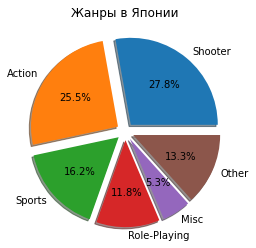

In [51]:
genres_sorted = genres.sort_values(by='jp',ascending=False)
genres_sorted.iloc[5] = genres_sorted.iloc[5:].sum()
genres_sorted = genres_sorted.rename(index={genres_sorted.iloc[5].name: 'Other'}).head(6)

plt.pie(genres_sorted['jp'], labels=genres_sorted.index,explode=(0.1,0.1,0.1,0.1,0.1,0.1),autopct='%1.1f%%',shadow=True)
plt.title('Жанры в Японии')
plt.show()

#### ТОП-5:
1. **Action** - почти половина пользователей предпочитает этот жанр игр.
2. **Shooter** - треть пользователей предпочитает этот жанр игр.
3. **Sports** 
4. **Role-Playing** 
5. **Misc** 

3 первых позиции являются одними из самых популярных жанров по миру.

**Вывод:**

- Action самый популярный жанр во всех регионах, причем игроков пости половина из всех, что подтвержала гистограмма ранее. Это может быть связано, как я уже писала, из-за цен на игры этого жанра.
- Предпочтения в жанрах Северо-американцев и японцев схожи.
- В Европе жанр Role-Playing гораздо популярнее других жанров, в т.ч. жанров в других регионах. Этот жанр также присутствует в топах других регионов.
- В целом, по жанрам, предпочтения в Европе отличаюся от Японии и Северной Америки.

### Влияние рейтинга ESRB <a id='id16'></a>

**1. Северная Америка (NA)**

Рассмотрим зависимость продаж от рейтинга:

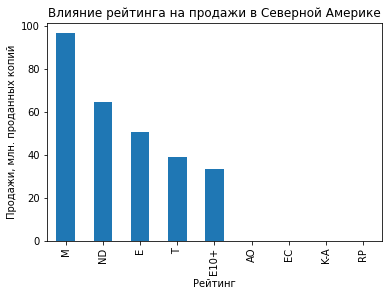

In [52]:
actual_games.pivot_table(index='rating',values=['na_sales'], aggfunc='sum').sort_values(by='na_sales', ascending=False).plot.bar(legend=False)
plt.title('Влияние рейтинга на продажи в Северной Америке');
plt.xlabel('Рейтинг');
plt.ylabel('Продажи, млн. проданных копий');

В Северной Америке большим спросом пользуются игры с рейтингом **M**. Игры, рейтинг которых не указан (то есть игры выпущенные в США и Канаде) находятся на 2 месте, игры с рейтингом **T** и **E10+** наименее популярны. 

То есть спрос на игры 17+ довольно велик, игры с рейтингом **M** явно пользуются спросом, можно предположить, что соответствующее содержание влияет на продажи. Тем не менее, т.к. игры без рейтинга продаются не намного хуже, то возможно это лишь совпадение. 

Игры с рейтингами **AO**, **EC**, **K-A** и **RP** совсем не пользуются спросом.

**2. Европа (EU)**

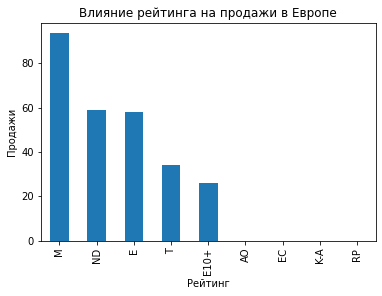

In [53]:
actual_games.pivot_table(index='rating',values=['eu_sales'], aggfunc='sum').sort_values(by='eu_sales', ascending=False).plot.bar(legend=False)
plt.title('Влияние рейтинга на продажи в Европе');
plt.xlabel('Рейтинг');
plt.ylabel('Продажи');

В Европе также большим спросом пользуются игры с рейтингом **M** и игры без рейтинга, игры с рейтингом **T** и **E10+** наименее популярны. 

Получается, что ситуация аналогична Северной Америке.

**3. Япония (JP)**

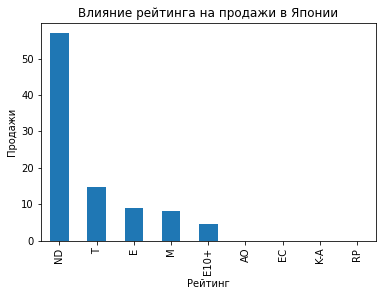

In [54]:
actual_games.pivot_table(index='rating',values=['jp_sales'], aggfunc='sum').sort_values(by='jp_sales', ascending=False).plot.bar(legend=False)
plt.title('Влияние рейтинга на продажи в Японии');
plt.xlabel('Рейтинг');
plt.ylabel('Продажи');

В Японии пользователи чаще предпочитают игры без рейтинга и игры с рейтингом **T** и **Е**.

Игры с рейтингами **AO**, **EC**, **K-A** и **RP** совсем не пользуются спросом.

По всем трем гистограммам, сложно сказать, что рейтинг игр существенно влияет на продажи. 

В общем, получается, что в Европе и Северной Америке наибольшим спросом пользуются игры, выпущенные в США и Канаде, рейтинг **М**, а игры с рейтингами **AO**, **EC**, **K-A** и **RP** совсем спросом не пользуются.

## Проверка гипотез <a id='id17'></a>

1. Средние пользовательские рейтинги платформ XOne и РС одинаковые <a id='id18'></a>

**Нулевая гипотеза:** Среднее пользовательского рейтинга платформы XOne равно среднему пользовательского рейтинга платформы PC.
**Альтернативная гипотеза:** Среднее пользовательского рейтинга платформы XOne не равно среднему пользовательского рейтинга платформы PC.

Я думаю, что можно предположить, что дисперсии выборок будут схожи, т.к. речь идет об оценках пользователей, распределление которых было приведено ранее и, в целом, большинство оценок расположено в интервале от 6 до 8.

Уровень статистической значимости выберем 5%, также по указзанным выше причинам.

In [56]:
from scipy import stats as st
alpha = 0.05

xone_user_score = actual_games_xone.query('~user_score.isna()')['user_score']
pc_user_score = actual_games.query('platform == "PC"').query('~user_score.isna()')['user_score']
results = st.ttest_ind(xone_user_score, pc_user_score)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


In [57]:
np.var(xone_user_score)

1.8795460055096425

In [58]:
np.var(pc_user_score)

2.8773743617307175

Гипотезу отвергнуть не получилось, то есть равенство средних оценок вероятно.

Т.к. выборки у нас небольшие, проверим:

In [59]:
print('Средняя оценка пользователей платформы PC: {0:.3f}'.format(pc_user_score.mean()))
print('Средняя оценка пользователей платформы Xone: {0:.3f}'.format(xone_user_score.mean()))

Средняя оценка пользователей платформы PC: 6.298
Средняя оценка пользователей платформы Xone: 6.595


Средние оценки равны с точностью до целого.

2. Средние пользовательские рейтинги жанров Action и Sports разные. <a id='id19'></a>

Используем критерий Стъюдента для оценки средних двух выборок оценок пользователей разных жанров. Нулевую гипотезу сформулируем как равенство двух средних. Используем двусторонний t-тест, т.к. нам нужно оценить равенство или не равенство средних.

**Нулевая гипотеза:** Средние пользовательские рейтинги жанров Action и Sports одинаковые.

**Альтернативная гипотеза:** Средние пользовательские рейтинги жанров Action и Sports разные.

Аналогично предполагаем, что дисперсии выборок будут схожи, т.к. речь идет об оценках пользователей, распределление которых было приведено ранее и, в целом, большинство оценок расположено в интервале от 6 до 8.

Уровень статистической значимости выберем 5%, также по указанным выше причинам. Наша задача глобально - опровергнуть нулевую гипотезу.

In [60]:
alpha = 0.05

action_user_score = actual_games.query('genre == "Action" & ~user_score.isna()')['user_score']
sports_user_score = actual_games.query('genre == "Sports" & ~user_score.isna()')['user_score']
results = st.ttest_ind(action_user_score, sports_user_score)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Нулевая гипотеза опровергнута, следовательно, средние оценки не равны.

In [61]:
print('Средняя оценка пользователей жанра Action: {0:.3f}'.format(action_user_score.mean()))
print('Средняя оценка пользователей жанра Sports: {0:.3f}'.format(sports_user_score.mean()))

Средняя оценка пользователей жанра Action: 6.761
Средняя оценка пользователей жанра Sports: 5.225


Действительно, оценки не равны.


## Общий вывод <a id='id20'></a>

- Платформа **PS4** является самой популярной на актуальный период, в общем ей практически не уступает платформа **XOne**. На этих платформах выходят наиболее прибыльные игры (игры с большими продажами), это стоит учесть
- После 2013 года количество выпускаемых игр резко упало, это может быть связано, например, с обновлением платформ у многих пользователей
- Средняя оценка игр пользователей - около **6**, что вполне ожидаемо 
- Оценки пользователей вероятнее не влияют на продажи игр, нежели наоборот
- **Shooter**, **Platform** и **Sports** самые прибыльные жанры
- Жанр **Action** является самым популярным
- **Strategy**, **Puzzle** и **Adventure** - самые неприбыльные жанры
- В Европе и Северной Америке большинство пользователей предпочитают игры с рейтингом **М**, то есть наибольшим спросом пользуются игры, выпущенные в США и Канаде
- В общем, т.к. велики продажи игр без рейтинга, то нельзя утверждать то, что пользователи делают выбор, исходя из него
- Средние оценки игр на платформах XOne и PC предположительно равны
- Средние оценки игр жанра Action и Sports не равны